# Predictive Maintenance using FD001 Dataset

This notebook explores explores the effectiveness of the Random Forest Model as a predictive maintenance model using the FD001 dataset from the NASA Turbofan Engine Degradation Simulation Data Set. The objective is to predict the Remaining Useful Life (RUL) of engines based on their sensor readings and operational settings. The Pandas, NumPy, Scikit-Learn and Matplotlib libraries are used.


# Random Forest Model

Random Forest is an ensemble learning method that is widely used for both classification and regression tasks. It works by constructing multiple decision trees during training and outputs the average prediction (for regression) or the majority vote (for classification) of the individual trees.

## Key Concepts:
1. Decision Tree:
    - A decision tree is a flowchart-like structure where each internal node represents a feature (or attribute), each branch represents a decision rule, and each leaf node represents the outcome.
    - It splits the data into subsets based on the most significant feature at each step.
2. Ensemble Learning:
    - Ensemble learning involves combining predictions of multiple models to improve overall performance.
    - Random Forest is an example of bagging (Bootstrap Aggregating), where multiple decision trees are trained on different subsets of data.
3. Bootstrap Sampling:
    - Each tree in the Random Forest is trained on a random subset of the training data, selected with replacement (bootstrap sample).
    - This means some samples may be used multiple times in the same tree, while others may not be used at all.
4. Random Feature Selection:
    - At each split in the tree, a random subset of features is selected, and the best split is chosen from this subset.
    - This helps to create diverse trees and reduces the correlation between individual trees, improving the ensemble's performance.

## Building a Random Forest
1. Bootstrap Sampling: 
    - Generate $ n $ different bootstrapped samples from the original dataset, where $ n $ is the number of trees in the forest.
2. Growing Trees:
    - For each bootstrapped sample, grow a decision tree by selecting the best split from a random subset of features at each node.
    - Continue splitting until a stop criterion is met (e.g. maximum depth, minimum number of samples per leaf).
3. Aggregating Predicitions:
    - For regression tasks, the final prediction is the average of predictions from all individual trees.
    - For classification tasks, the final prediction is the majority vote from all individual trees.

## Advantages of Random Forest
- Improved Accuracy: By aggregating the predictions of multiple trees, Random Forest generally produces more accurate and stable predicitions compares to a single decision tree.
- Robustness of Overfitting: Random Forest reduces overfitting by averaging multiple decision trees, which are trained on different parts of the data.
- Feature Importance: Random Forest can provide estimates of feature importance, which can be used to understand the data better and for feature selection.

## Disadvantages of Random Forest
- Complexity: Although Random Forest is robust and powerful, it can be more complex and computationally intensive compared to a single decision tree.
- Intepretability: While Random Forest is more intepretable than some other machine learning models (e.g. deep learning), it is still less interpretable than a single decision tree.
    

In [2]:
# Data Loading, Preprocessing, and Feature Engineering
import numpy as np
import pandas as pd

# Normalization
from sklearn.preprocessing import StandardScaler

# Model Training
import tensorflow as tf

# Random Forest
from sklearn.ensemble import RandomForestRegressor # Ensemble learning method that constructs multiple decision trees and outputs the average prediction
from sklearn.model_selection import train_test_split # Splits the dataset into training and testing/validation sets

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
# Mean Squared Error - Calculates the root mean squared error regression loss to evaluate the performance of the model
# R^2 - Computes the R^2 to evaluate the goodness of fit of the model

# Visualization
import matplotlib.pyplot as plt

In [3]:
# Load data
file_prefix = 'FD001'
train_data_raw = pd.read_csv(f'CMAPSSData/train_{file_prefix}.txt', sep=' ', header=None)
test_data_raw = pd.read_csv(f'CMAPSSData/test_{file_prefix}.txt', sep=' ', header=None)
rul_data_raw = pd.read_csv(f'CMAPSSData/RUL_{file_prefix}.txt', header=None)

In [16]:
# Data Preprocessing - Data Cleaning
train_data = train_data_raw.drop(columns=[26, 27])
test_data = test_data_raw.drop(columns=[26, 27])
rul_data = rul_data_raw.copy(deep=True)

column_names = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
               ['sensor_measurement_' + str(i) for i in range(1, 22)]

train_data.columns = column_names
test_data.columns = column_names
rul_data.columns = ['RUL']

# print(train_data.head())
# print(test_data.head())
# print(rul_data.head())

In [17]:
# Data Preprocessing - Normalization
scaler = StandardScaler()
train_data[train_data.columns[5:]] = scaler.fit_transform(train_data[train_data.columns[5:]].values)
test_data[test_data.columns[5:]] = scaler.transform(test_data[test_data.columns[5:]].values)

In [18]:
# Data Preprocessing - RUL Calculation
train_data['RUL'] = train_data.groupby('unit_number')['time_in_cycles'].transform("max") - train_data['time_in_cycles']

In [19]:
# Feature Engineering
# Function to create aggregate features
def create_aggregate_features(data):
    features = data.groupby('unit_number').agg({
        'time_in_cycles': ['max'],
        'operational_setting_1': ['mean', 'std', 'last'],
        'operational_setting_2': ['mean', 'std', 'last'],
        'operational_setting_3': ['mean', 'std', 'last'],
        'sensor_measurement_1': ['mean', 'std', 'last'],
        'sensor_measurement_2': ['mean', 'std', 'last'],
        'sensor_measurement_3': ['mean', 'std', 'last'],
        'sensor_measurement_4': ['mean', 'std', 'last'],
        'sensor_measurement_5': ['mean', 'std', 'last'],
        'sensor_measurement_6': ['mean', 'std', 'last'],
        'sensor_measurement_7': ['mean', 'std', 'last'],
        'sensor_measurement_8': ['mean', 'std', 'last'],
        'sensor_measurement_9': ['mean', 'std', 'last'],
        'sensor_measurement_10': ['mean', 'std', 'last'],
        'sensor_measurement_11': ['mean', 'std', 'last'],
        'sensor_measurement_12': ['mean', 'std', 'last'],
        'sensor_measurement_13': ['mean', 'std', 'last'],
        'sensor_measurement_14': ['mean', 'std', 'last'],
        'sensor_measurement_15': ['mean', 'std', 'last'],
        'sensor_measurement_16': ['mean', 'std', 'last'],
        'sensor_measurement_17': ['mean', 'std', 'last'],
        'sensor_measurement_18': ['mean', 'std', 'last'],
        'sensor_measurement_19': ['mean', 'std', 'last'],
        'sensor_measurement_20': ['mean', 'std', 'last'],
        'sensor_measurement_21': ['mean', 'std', 'last'],
    })
    features.columns = ['_'.join(col) for col in features.columns]
    return features

# Create aggregate features for training and test data
train_features = create_aggregate_features(train_data)
test_features = create_aggregate_features(test_data)

# Merge RUL values for training data
train_features = train_features.merge(train_data[['unit_number', 'RUL']].drop_duplicates(), on='unit_number', how='left')


In [20]:
# Model Training - Random Forest
# Split training data into train and validation sets
X = train_features.drop(columns=['RUL', 'unit_number'])
y = train_features['RUL']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = rf_model.predict(X_val)

In [21]:
# Model Evaluation - On Validation Set
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation RMSE: {val_rmse}')
print(f'Validation R²: {val_r2}')

Validation RMSE: 63.88143166385002
Validation R²: 0.106802296871366


In [22]:
# Model Evaluation - On Test Set
# Predict on test set
test_features = test_features.reset_index()
X_test = test_features.drop(columns=['unit_number'])
y_test_pred = rf_model.predict(X_test)

# Align predicted RUL with actual RUL from the test set
rul_data = rul_data.iloc[:len(y_test_pred)]

# Evaluate the model on the test set
test_rmse = np.sqrt(mean_squared_error(rul_data, y_test_pred))
test_r2 = r2_score(rul_data, y_test_pred)

print(f'Test RMSE: {test_rmse}')
print(f'Test R²: {test_r2}')

Test RMSE: 49.41665860842533
Test R²: -0.41412307450525376


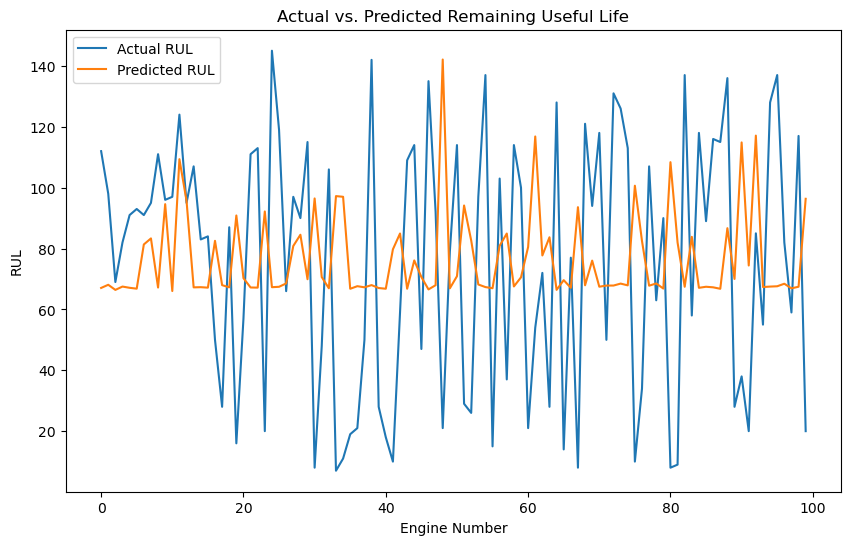

In [23]:
# Visualization - Plot actual vs. predicted RUL
plt.figure(figsize=(10, 6))
plt.plot(rul_data.values, label='Actual RUL')
plt.plot(y_test_pred, label='Predicted RUL')
plt.title('Actual vs. Predicted Remaining Useful Life')
plt.xlabel('Engine Number')
plt.ylabel('RUL')
plt.legend()
plt.show()

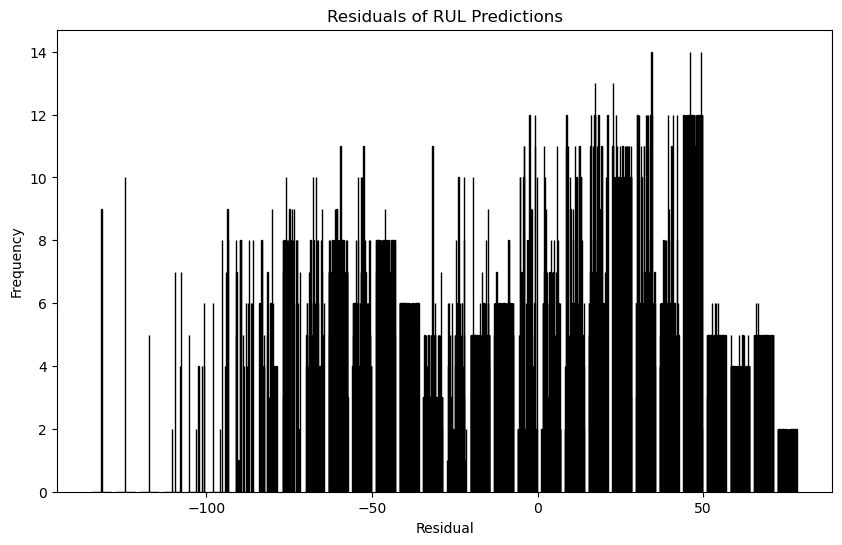

In [24]:
# Visualization Plot residuals
residuals = rul_data.values - y_test_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Residuals of RUL Predictions')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

# Conclusion

In this notebook, a predictive maintenance model was built using the FD001 dataset. A Random Forest model was trained to predict the Remaining Useful Life (RUL) of engines based on their sensor readings and operational settings. The model was evaluated using RMSE and R² scores, and the results were visualized to compare the actual vs. predicted RUL.
